# 4.6 無情報事前分布

## インポート・設定

In [31]:
import dataclasses
import warnings
from numbers import Number

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Math
from scipy import special, stats

In [32]:
sns.set_theme()
warnings.simplefilter("ignore")
RANDM_STATE = np.random.default_rng(seed=0)

## 解答

### モンテカルロサンプリングで求める

モンテカルロサンプリングにより、 $\theta \sim \text{Beta}(1, 1)$ からサンプリングを行い、
$\gamma = \log \frac{\theta}{1 - \theta} = \text{logit}(\theta)$ と変換した $\gamma$ の分布を観察する。

In [33]:
@dataclasses.dataclass
class BetaDist:
    """ベータ分布のパラメータを格納するクラス"""

    a: Number
    b: Number

    @property
    def rv(self):
        return stats.beta(a=self.a, b=self.b)

    def sample(self, size) -> np.ndarray:
        return self.rv.rvs(size=size, random_state=RANDM_STATE)

In [34]:
n_draws = 1_000_000


def sample_theta_gamma(n_draws: int):
    theta = BetaDist(a=1, b=1).sample(n_draws)
    gamma = special.logit(theta)

    return pd.DataFrame({"theta": theta, "gamma": gamma})


df_sample = sample_theta_gamma(n_draws)
df_sample.describe()

,theta,gamma
count,1.000000e+06,1000000.000000
mean,5.000836e-01,0.000674
std,2.886385e-01,1.812318
min,7.116599e-07,-14.155665
25%,2.500168e-01,-1.098522
50%,5.003146e-01,0.001258
75%,7.500412e-01,1.098832
max,9.999990e-01,13.856179


歪度と尖度を見てみる。
歪度はどちらともゼロに近い値であり、左右対称の分布になっていることが分かる。
尖度は、$\theta$ については $-\frac{6}{5} = - 1.2$ に近い値となっており、
[連続一様分布](https://ja.wikipedia.org/wiki/%E9%80%A3%E7%B6%9A%E4%B8%80%E6%A7%98%E5%88%86%E5%B8%83)
の理論値と一致している。
$\gamma$ については、およそ $1.2$ であり、正規分布より大きい尖度を持っていることがわかる。

In [35]:
df_sample.agg(["skew", "kurt"])

,theta,gamma
skew,-0.001292,0.004230
kurt,-1.200908,1.197523


ヒストグラムを描画する。
$\gamma$ は0付近に局在する分布であることがわかる。
$\gamma = \text{logit}(\theta)$ は $(-\infty, \infty)$ の範囲の値をとりうるので、この $\gamma$ の分布は無情報分布であるとは言えない。

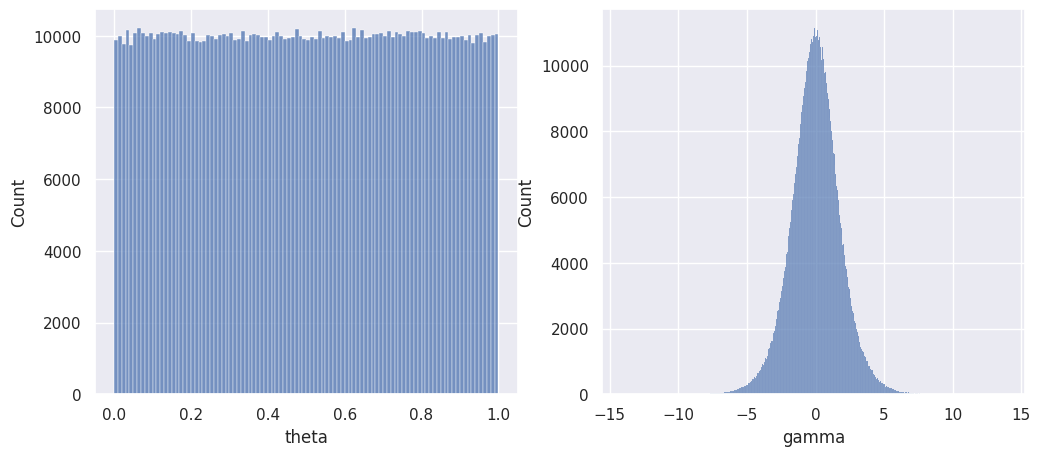

In [36]:
def plot_histgram(df_sample):
    fig, axes = plt.subplot_mosaic("AB", figsize=(12, 5))
    sns.histplot(df_sample, x="theta", ax=axes["A"])
    sns.histplot(df_sample, x="gamma", ax=axes["B"])


plot_histgram(df_sample)

### 解析的に求める

$\theta \sim \text{Beta}(1, 1)$ の密度関数:

$$
p(\theta) = 1 \quad (0 \leq \theta \leq 1)
$$

変数変換 $\gamma = \log \frac{\theta}{1 - \theta}$ のヤコビアン:

$$
\begin{aligned}
\frac{d \theta}{d \gamma}
&=
\frac{d}{d \gamma} \left \{ \frac{e^{\gamma}}{1 + e^{\gamma}} \right\}
\\
&=
 \frac{e^{\gamma}}{(1 + e^{\gamma})^2} 
\end{aligned}
$$

$\gamma$ の密度関数:

$$
\begin{aligned}
p(\gamma)
&=
p(\theta) \times \left | \frac{d \theta}{d \gamma} \right|
\\
&=
1 \times \frac{e^{\gamma}}{(1 + e^{\gamma})^2} 
\\
&=
\frac{e^{\gamma}}{(1 + e^{\gamma})^2} 
\end{aligned}
$$

これは [ロジスティック分布](https://en.wikipedia.org/wiki/Logistic_distribution) の密度関数である。

ロジスティック分布の分布関数と $\gamma$ のヒストグラムを比べてみる。
きれいに一致することがわかる。

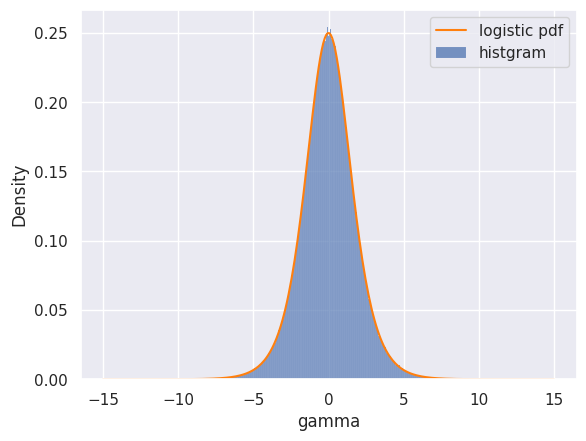

In [37]:
def plot_logistic(df_sample):
    ax = sns.histplot(df_sample, x="gamma", stat="density", label="histgram")

    x = np.linspace(-15, 15, 300)
    pdf = stats.logistic.pdf(x=x)

    sns.lineplot(x=x, y=pdf, ax=ax, label="logistic pdf", color="tab:orange")


plot_logistic(df_sample)